# Install and Import Libraries

In [ ]:
!pip install torch torchvision

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os
import itertools
import time
import random
import matplotlib.pyplot as plt
from PIL import Image


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

# Mount Google Drive

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
from google.colab import drive

# Check if drive is already mounted
import os
if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')
else:
  print("Google Drive is already mounted at /content/drive")


Google Drive is already mounted at /content/drive


# Dataset Loading and Transformations

In [ ]:
import os
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Custom Dataset
class CustomImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_paths = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if img.endswith(('png', 'jpg', 'jpeg'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, 0  # dummy label for compatibility

# Transform
transform = transforms.Compose([
    transforms.Resize(286),
    transforms.RandomCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Dataset paths
dataset_path = '/content/drive/MyDrive/CV_PROJ_DATA/dataset'
trainA_path = os.path.join(dataset_path, 'trainA')
trainB_path = os.path.join(dataset_path, 'trainB')

# Datasets
datasetA = CustomImageDataset(trainA_path, transform=transform)
datasetB = CustomImageDataset(trainB_path, transform=transform)


# Create DataLoaders

In [ ]:
# Dataloaders
train_loader_A = DataLoader(datasetA, batch_size=1, shuffle=True)
train_loader_B = DataLoader(datasetB, batch_size=1, shuffle=True)

In [ ]:
!ls /content/drive/MyDrive/CV_PROJ_DATA/dataset # to verify this folder contains trainA and trainB.


testA  testB  trainA  trainB


# Define Residual Block

In [ ]:
# Basic building blocks
class ResidualBlock(nn.Module):
    def __init__(self, features):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(features, features, 3),
            nn.InstanceNorm2d(features),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(features, features, 3),
            nn.InstanceNorm2d(features)
        )

    def forward(self, x):
        return x + self.block(x)


# Define Generator Model

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(True),

            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(True),

            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(True),
        ]

        for _ in range(6):  # Lightweight (use 6 ResNet blocks instead of 9)
            model += [ResidualBlock(256)]

        model += [
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(True),

            nn.ReflectionPad2d(3),
            nn.Conv2d(64, 3, 7),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


# Define Discriminator Model

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        def discriminator_block(in_filters, out_filters, stride=2):
            return [
                nn.Conv2d(in_filters, out_filters, 4, stride, 1),
                nn.InstanceNorm2d(out_filters),
                nn.LeakyReLU(0.2, inplace=True)
            ]

        self.model = nn.Sequential(
            *discriminator_block(3, 64, stride=2),
            *discriminator_block(64, 128, stride=2),
            *discriminator_block(128, 256, stride=2),
            *discriminator_block(256, 512, stride=1),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, x):
        return self.model(x)


# Initialize Models and Optimizers

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

G_AB = Generator().to(device)
G_BA = Generator().to(device)
D_A = Discriminator().to(device)
D_B = Discriminator().to(device)

optimizer_G = optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=2e-4, betas=(0.5, 0.999))
optimizer_D_A = optim.Adam(D_A.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=2e-4, betas=(0.5, 0.999))

# Define Loss Functions

In [ ]:
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()


# Training Block:Checkpoint Handling,Training Utilities,Training Loop	,Save Models and Outputs,Visualize Training Progression

In [ ]:
import os
import torch
from torchvision.utils import save_image
from tqdm import tqdm

# Create folders if they don't exist
os.makedirs('/content/drive/MyDrive/cyclegan_output', exist_ok=True)
os.makedirs('/content/drive/MyDrive/cyclegan_checkpoints', exist_ok=True)

# Labels
real_label = torch.ones((1, 1, 30, 30), device=device)
fake_label = torch.zeros((1, 1, 30, 30), device=device)

# Sample images function
def sample_images(epoch):
    imgs = next(iter(train_loader_A))
    real_A = imgs[0].to(device)

    fake_B = G_AB(real_A)
    fake_A = G_BA(fake_B)

    imgs = torch.cat([real_A, fake_B, fake_A], dim=0)
    save_image(imgs, f"/content/drive/MyDrive/cyclegan_output/{epoch}.png", nrow=3, normalize=True)

# Training settings
num_epochs = 50
start_epoch = 1

# Check if checkpoint exists
checkpoint_files = [f for f in os.listdir('/content/drive/MyDrive/cyclegan_checkpoints') if f.endswith('.pth')]
if checkpoint_files:
    latest_checkpoint = sorted(checkpoint_files, key=lambda x: int(x.split('_')[-1].split('.')[0].replace('latest', '0')))[-1]
    checkpoint_path = f"/content/drive/MyDrive/cyclegan_checkpoints/{latest_checkpoint}"
    checkpoint = torch.load(checkpoint_path, map_location=device)

    G_AB.load_state_dict(checkpoint['G_AB_state_dict'])
    G_BA.load_state_dict(checkpoint['G_BA_state_dict'])
    D_A.load_state_dict(checkpoint['D_A_state_dict'])
    D_B.load_state_dict(checkpoint['D_B_state_dict'])
    optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    optimizer_D_A.load_state_dict(checkpoint['optimizer_D_A_state_dict'])
    optimizer_D_B.load_state_dict(checkpoint['optimizer_D_B_state_dict'])
    start_epoch = checkpoint['epoch'] + 1

    print(f"✅ Resumed from checkpoint: {latest_checkpoint} (starting from epoch {start_epoch})")
else:
    print("🚀 Starting training from scratch.")

# Training loop
for epoch in range(start_epoch, num_epochs + 1):
    loop = tqdm(zip(train_loader_A, train_loader_B), desc=f"Epoch [{epoch}/{num_epochs}]", leave=False)

    for i, (data_A, data_B) in enumerate(loop):
        real_A = data_A[0].to(device)
        real_B = data_B[0].to(device)

        # -----------------
        #  Train Generators
        # -----------------
        optimizer_G.zero_grad()

        fake_B = G_AB(real_A)
        fake_A = G_BA(real_B)

        loss_GAN_AB = criterion_GAN(D_B(fake_B), real_label)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), real_label)

        recovered_A = G_BA(fake_B)
        recovered_B = G_AB(fake_A)

        loss_cycle_A = criterion_cycle(recovered_A, real_A)
        loss_cycle_B = criterion_cycle(recovered_B, real_B)

        loss_identity_A = criterion_identity(G_BA(real_A), real_A)
        loss_identity_B = criterion_identity(G_AB(real_B), real_B)

        loss_G = (loss_GAN_AB + loss_GAN_BA) + 10 * (loss_cycle_A + loss_cycle_B) + 5 * (loss_identity_A + loss_identity_B)

        loss_G.backward()
        optimizer_G.step()

        # -----------------------
        #  Train Discriminator A
        # -----------------------
        optimizer_D_A.zero_grad()

        loss_real = criterion_GAN(D_A(real_A), real_label)
        loss_fake = criterion_GAN(D_A(fake_A.detach()), fake_label)

        loss_D_A = (loss_real + loss_fake) * 0.5
        loss_D_A.backward()
        optimizer_D_A.step()

        # -----------------------
        #  Train Discriminator B
        # -----------------------
        optimizer_D_B.zero_grad()

        loss_real = criterion_GAN(D_B(real_B), real_label)
        loss_fake = criterion_GAN(D_B(fake_B.detach()), fake_label)

        loss_D_B = (loss_real + loss_fake) * 0.5
        loss_D_B.backward()
        optimizer_D_B.step()

        loop.set_postfix({
            'Loss_G': loss_G.item(),
            'Loss_D_A': loss_D_A.item(),
            'Loss_D_B': loss_D_B.item()
        })

        # ✅ Save a latest checkpoint every 100 iterations
        if (i + 1) % 100 == 0:
            latest_save_path = "/content/drive/MyDrive/cyclegan_checkpoints/cyclegan_latest.pth"
            torch.save({
                'G_AB_state_dict': G_AB.state_dict(),
                'G_BA_state_dict': G_BA.state_dict(),
                'D_A_state_dict': D_A.state_dict(),
                'D_B_state_dict': D_B.state_dict(),
                'optimizer_G_state_dict': optimizer_G.state_dict(),
                'optimizer_D_A_state_dict': optimizer_D_A.state_dict(),
                'optimizer_D_B_state_dict': optimizer_D_B.state_dict(),
                'epoch': epoch
            }, latest_save_path)
            torch.cuda.empty_cache()
            print(f"💾 Saved latest checkpoint at iteration {i+1}")

    # ✅ Save sample images every epoch
    sample_images(epoch)

    # ✅ Save checkpoint every epoch (separate file)
    checkpoint_save_path = f"/content/drive/MyDrive/cyclegan_checkpoints/cyclegan_epoch_{epoch}.pth"
    torch.save({
        'G_AB_state_dict': G_AB.state_dict(),
        'G_BA_state_dict': G_BA.state_dict(),
        'D_A_state_dict': D_A.state_dict(),
        'D_B_state_dict': D_B.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_A_state_dict': optimizer_D_A.state_dict(),
        'optimizer_D_B_state_dict': optimizer_D_B.state_dict(),
        'epoch': epoch,
    }, checkpoint_save_path)
    torch.cuda.empty_cache()
    print(f"✅ Saved checkpoint at epoch {epoch}")

print("🏁 Training Complete!")


✅ Resumed from checkpoint: cyclegan_epoch_42.pth (starting from epoch 43)


Epoch [43/50]: 100it [02:57,  6.68s/it, Loss_G=4.6, Loss_D_A=0.164, Loss_D_B=0.159]

💾 Saved latest checkpoint at iteration 100


Epoch [43/50]: 200it [04:42,  1.36s/it, Loss_G=2.72, Loss_D_A=0.199, Loss_D_B=0.312]

💾 Saved latest checkpoint at iteration 200


Epoch [43/50]: 300it [06:30,  1.19s/it, Loss_G=5.08, Loss_D_A=0.428, Loss_D_B=0.271]

💾 Saved latest checkpoint at iteration 300


Epoch [43/50]: 400it [08:16,  1.28s/it, Loss_G=3.08, Loss_D_A=0.409, Loss_D_B=0.122]

💾 Saved latest checkpoint at iteration 400


Epoch [43/50]: 500it [10:04,  1.25s/it, Loss_G=3.42, Loss_D_A=0.107, Loss_D_B=0.117]

💾 Saved latest checkpoint at iteration 500


Epoch [43/50]: 600it [11:50,  1.21s/it, Loss_G=4.75, Loss_D_A=0.105, Loss_D_B=0.127]

💾 Saved latest checkpoint at iteration 600


Epoch [43/50]: 700it [13:34,  1.19s/it, Loss_G=3.81, Loss_D_A=0.404, Loss_D_B=0.431]

💾 Saved latest checkpoint at iteration 700


Epoch [43/50]: 800it [15:19,  1.32s/it, Loss_G=3.49, Loss_D_A=0.256, Loss_D_B=0.411]

💾 Saved latest checkpoint at iteration 800


Epoch [43/50]: 900it [17:08,  1.28s/it, Loss_G=3.98, Loss_D_A=0.112, Loss_D_B=0.177]

💾 Saved latest checkpoint at iteration 900


Epoch [43/50]: 1000it [18:51,  1.18s/it, Loss_G=5.06, Loss_D_A=0.205, Loss_D_B=0.232]

💾 Saved latest checkpoint at iteration 1000


Epoch [43/50]: 1100it [20:40,  1.22s/it, Loss_G=4.37, Loss_D_A=0.279, Loss_D_B=0.262]

💾 Saved latest checkpoint at iteration 1100


Epoch [43/50]: 1200it [22:26,  1.19s/it, Loss_G=5.08, Loss_D_A=0.189, Loss_D_B=0.26]

💾 Saved latest checkpoint at iteration 1200


Epoch [43/50]: 1300it [24:14,  1.21s/it, Loss_G=4.05, Loss_D_A=0.165, Loss_D_B=0.161]

💾 Saved latest checkpoint at iteration 1300


Epoch [43/50]: 1400it [26:01,  1.11s/it, Loss_G=2.98, Loss_D_A=0.278, Loss_D_B=0.24]

💾 Saved latest checkpoint at iteration 1400


Epoch [43/50]: 1500it [27:55,  1.40s/it, Loss_G=5.05, Loss_D_A=0.0319, Loss_D_B=0.0523]

💾 Saved latest checkpoint at iteration 1500


Epoch [43/50]: 1600it [29:47,  1.23s/it, Loss_G=4.94, Loss_D_A=0.0572, Loss_D_B=0.129]

💾 Saved latest checkpoint at iteration 1600


Epoch [43/50]: 1700it [31:34,  1.11s/it, Loss_G=3.51, Loss_D_A=0.339, Loss_D_B=0.384]

💾 Saved latest checkpoint at iteration 1700


Epoch [43/50]: 1800it [33:23,  1.23s/it, Loss_G=5.54, Loss_D_A=0.144, Loss_D_B=0.107]

💾 Saved latest checkpoint at iteration 1800


Epoch [43/50]: 1900it [35:08,  1.29s/it, Loss_G=2.54, Loss_D_A=0.23, Loss_D_B=0.201]

💾 Saved latest checkpoint at iteration 1900


Epoch [43/50]: 2000it [36:57,  1.31s/it, Loss_G=3.54, Loss_D_A=0.142, Loss_D_B=0.185]

💾 Saved latest checkpoint at iteration 2000


Epoch [43/50]: 2100it [38:41,  1.18s/it, Loss_G=2.93, Loss_D_A=0.0894, Loss_D_B=0.0498]

💾 Saved latest checkpoint at iteration 2100


Epoch [43/50]: 2200it [40:26,  1.52s/it, Loss_G=4.47, Loss_D_A=0.317, Loss_D_B=0.418]

💾 Saved latest checkpoint at iteration 2200


Epoch [43/50]: 2300it [42:11,  1.21s/it, Loss_G=3.88, Loss_D_A=0.407, Loss_D_B=0.395]

💾 Saved latest checkpoint at iteration 2300


Epoch [43/50]: 2400it [43:59,  1.33s/it, Loss_G=3.2, Loss_D_A=0.168, Loss_D_B=0.192]

💾 Saved latest checkpoint at iteration 2400


Epoch [43/50]: 2500it [45:45,  1.20s/it, Loss_G=3.54, Loss_D_A=0.427, Loss_D_B=0.231]

💾 Saved latest checkpoint at iteration 2500


✅ Saved checkpoint at epoch 43


Epoch [44/50]: 100it [00:59,  1.33it/s, Loss_G=5.13, Loss_D_A=0.277, Loss_D_B=0.18]

💾 Saved latest checkpoint at iteration 100


Epoch [44/50]: 200it [01:57,  1.23it/s, Loss_G=4.03, Loss_D_A=0.116, Loss_D_B=0.191]

💾 Saved latest checkpoint at iteration 200


Epoch [44/50]: 300it [02:56,  1.33it/s, Loss_G=3.46, Loss_D_A=0.144, Loss_D_B=0.146]

💾 Saved latest checkpoint at iteration 300


Epoch [44/50]: 400it [03:55,  1.17it/s, Loss_G=6.87, Loss_D_A=0.17, Loss_D_B=0.068]

💾 Saved latest checkpoint at iteration 400


Epoch [44/50]: 500it [04:55,  1.34it/s, Loss_G=3.11, Loss_D_A=0.124, Loss_D_B=0.173]

💾 Saved latest checkpoint at iteration 500


Epoch [44/50]: 600it [05:53,  1.29it/s, Loss_G=6.07, Loss_D_A=0.231, Loss_D_B=0.0442]

💾 Saved latest checkpoint at iteration 600


Epoch [44/50]: 700it [06:52,  1.33it/s, Loss_G=5.32, Loss_D_A=0.214, Loss_D_B=0.152]

💾 Saved latest checkpoint at iteration 700


Epoch [44/50]: 800it [07:50,  1.29it/s, Loss_G=3.4, Loss_D_A=0.213, Loss_D_B=0.138]

💾 Saved latest checkpoint at iteration 800


Epoch [44/50]: 900it [08:49,  1.32it/s, Loss_G=3.55, Loss_D_A=0.0736, Loss_D_B=0.179]

💾 Saved latest checkpoint at iteration 900


Epoch [44/50]: 1000it [09:48,  1.29it/s, Loss_G=3.56, Loss_D_A=0.283, Loss_D_B=0.213]

💾 Saved latest checkpoint at iteration 1000


Epoch [44/50]: 1100it [10:47,  1.19it/s, Loss_G=3.93, Loss_D_A=0.16, Loss_D_B=0.0511]

💾 Saved latest checkpoint at iteration 1100


Epoch [44/50]: 1200it [11:46,  1.30it/s, Loss_G=4.41, Loss_D_A=0.296, Loss_D_B=0.288]

💾 Saved latest checkpoint at iteration 1200


Epoch [44/50]: 1300it [12:45,  1.29it/s, Loss_G=3.52, Loss_D_A=0.225, Loss_D_B=0.329]

💾 Saved latest checkpoint at iteration 1300


Epoch [44/50]: 1400it [13:44,  1.32it/s, Loss_G=3.62, Loss_D_A=0.0602, Loss_D_B=0.0504]

💾 Saved latest checkpoint at iteration 1400


Epoch [44/50]: 1500it [14:42,  1.30it/s, Loss_G=4.21, Loss_D_A=0.316, Loss_D_B=0.273]

💾 Saved latest checkpoint at iteration 1500


Epoch [44/50]: 1600it [15:40,  1.32it/s, Loss_G=4.7, Loss_D_A=0.0419, Loss_D_B=0.0554]

💾 Saved latest checkpoint at iteration 1600


Epoch [44/50]: 1700it [16:39,  1.33it/s, Loss_G=3.24, Loss_D_A=0.569, Loss_D_B=0.48]

💾 Saved latest checkpoint at iteration 1700


Epoch [44/50]: 1800it [17:38,  1.24it/s, Loss_G=4.81, Loss_D_A=0.091, Loss_D_B=0.147]

💾 Saved latest checkpoint at iteration 1800


Epoch [44/50]: 1900it [18:37,  1.33it/s, Loss_G=3.8, Loss_D_A=0.144, Loss_D_B=0.222]

💾 Saved latest checkpoint at iteration 1900


Epoch [44/50]: 2000it [19:36,  1.17it/s, Loss_G=4.24, Loss_D_A=0.0482, Loss_D_B=0.12]

💾 Saved latest checkpoint at iteration 2000


Epoch [44/50]: 2100it [20:35,  1.34it/s, Loss_G=3.82, Loss_D_A=0.192, Loss_D_B=0.25]

💾 Saved latest checkpoint at iteration 2100


Epoch [44/50]: 2200it [21:34,  1.31it/s, Loss_G=3.57, Loss_D_A=0.142, Loss_D_B=0.24]

💾 Saved latest checkpoint at iteration 2200


Epoch [44/50]: 2300it [22:32,  1.33it/s, Loss_G=5.35, Loss_D_A=0.154, Loss_D_B=0.282]

💾 Saved latest checkpoint at iteration 2300


Epoch [44/50]: 2400it [23:31,  1.33it/s, Loss_G=4.65, Loss_D_A=0.156, Loss_D_B=0.162]

💾 Saved latest checkpoint at iteration 2400


Epoch [44/50]: 2500it [24:29,  1.32it/s, Loss_G=3.4, Loss_D_A=0.181, Loss_D_B=0.128]

💾 Saved latest checkpoint at iteration 2500


✅ Saved checkpoint at epoch 44


Epoch [45/50]: 100it [00:59,  1.30it/s, Loss_G=4.07, Loss_D_A=0.232, Loss_D_B=0.0521]

💾 Saved latest checkpoint at iteration 100


Epoch [45/50]: 200it [01:58,  1.30it/s, Loss_G=3.6, Loss_D_A=0.348, Loss_D_B=0.298]

💾 Saved latest checkpoint at iteration 200


Epoch [45/50]: 300it [02:56,  1.32it/s, Loss_G=4.65, Loss_D_A=0.144, Loss_D_B=0.153]

💾 Saved latest checkpoint at iteration 300


Epoch [45/50]: 400it [03:55,  1.31it/s, Loss_G=5.99, Loss_D_A=0.112, Loss_D_B=0.145]

💾 Saved latest checkpoint at iteration 400


Epoch [45/50]: 500it [04:53,  1.30it/s, Loss_G=3.4, Loss_D_A=0.133, Loss_D_B=0.0664]

💾 Saved latest checkpoint at iteration 500


Epoch [45/50]: 600it [05:53,  1.32it/s, Loss_G=3.64, Loss_D_A=0.298, Loss_D_B=0.37]

💾 Saved latest checkpoint at iteration 600


Epoch [45/50]: 700it [06:51,  1.23it/s, Loss_G=3.15, Loss_D_A=0.396, Loss_D_B=0.338]

💾 Saved latest checkpoint at iteration 700


Epoch [45/50]: 800it [07:51,  1.33it/s, Loss_G=4.46, Loss_D_A=0.109, Loss_D_B=0.16]

💾 Saved latest checkpoint at iteration 800


Epoch [45/50]: 900it [08:49,  1.22it/s, Loss_G=3.45, Loss_D_A=0.25, Loss_D_B=0.185]

💾 Saved latest checkpoint at iteration 900


Epoch [45/50]: 1000it [09:48,  1.33it/s, Loss_G=4.29, Loss_D_A=0.0736, Loss_D_B=0.239]

💾 Saved latest checkpoint at iteration 1000


Epoch [45/50]: 1100it [10:46,  1.33it/s, Loss_G=4.48, Loss_D_A=0.104, Loss_D_B=0.0739]

💾 Saved latest checkpoint at iteration 1100


Epoch [45/50]: 1200it [11:45,  1.31it/s, Loss_G=4.4, Loss_D_A=0.0745, Loss_D_B=0.07]

💾 Saved latest checkpoint at iteration 1200


Epoch [45/50]: 1300it [12:44,  1.31it/s, Loss_G=4.16, Loss_D_A=0.0964, Loss_D_B=0.113]

💾 Saved latest checkpoint at iteration 1300


Epoch [45/50]: 1400it [13:42,  1.30it/s, Loss_G=2.9, Loss_D_A=0.268, Loss_D_B=0.332]

💾 Saved latest checkpoint at iteration 1400


Epoch [45/50]: 1500it [14:41,  1.33it/s, Loss_G=3.77, Loss_D_A=0.251, Loss_D_B=0.14]

💾 Saved latest checkpoint at iteration 1500


Epoch [45/50]: 1600it [15:40,  1.19it/s, Loss_G=4.13, Loss_D_A=0.264, Loss_D_B=0.111]

💾 Saved latest checkpoint at iteration 1600


Epoch [45/50]: 1700it [16:39,  1.32it/s, Loss_G=3.18, Loss_D_A=0.157, Loss_D_B=0.0677]

💾 Saved latest checkpoint at iteration 1700


Epoch [45/50]: 1800it [17:38,  1.31it/s, Loss_G=4.46, Loss_D_A=0.233, Loss_D_B=0.17]

💾 Saved latest checkpoint at iteration 1800


Epoch [45/50]: 1900it [18:37,  1.34it/s, Loss_G=5.18, Loss_D_A=0.0555, Loss_D_B=0.0946]

💾 Saved latest checkpoint at iteration 1900


Epoch [45/50]: 2000it [19:35,  1.30it/s, Loss_G=2.95, Loss_D_A=0.241, Loss_D_B=0.174]

💾 Saved latest checkpoint at iteration 2000


Epoch [45/50]: 2100it [20:34,  1.18it/s, Loss_G=2.89, Loss_D_A=0.325, Loss_D_B=0.506]

💾 Saved latest checkpoint at iteration 2100


Epoch [45/50]: 2200it [21:34,  1.33it/s, Loss_G=3.02, Loss_D_A=0.169, Loss_D_B=0.248]

💾 Saved latest checkpoint at iteration 2200


Epoch [45/50]: 2300it [22:32,  1.27it/s, Loss_G=4.91, Loss_D_A=0.102, Loss_D_B=0.252]

💾 Saved latest checkpoint at iteration 2300


Epoch [45/50]: 2400it [23:31,  1.32it/s, Loss_G=2.88, Loss_D_A=0.159, Loss_D_B=0.0729]

💾 Saved latest checkpoint at iteration 2400


Epoch [45/50]: 2500it [24:30,  1.32it/s, Loss_G=3.82, Loss_D_A=0.124, Loss_D_B=0.15]

💾 Saved latest checkpoint at iteration 2500


✅ Saved checkpoint at epoch 45


Epoch [46/50]: 100it [01:00,  1.21it/s, Loss_G=4.12, Loss_D_A=0.189, Loss_D_B=0.261]

💾 Saved latest checkpoint at iteration 100


Epoch [46/50]: 200it [02:00,  1.34it/s, Loss_G=3.92, Loss_D_A=0.0645, Loss_D_B=0.18]

💾 Saved latest checkpoint at iteration 200


Epoch [46/50]: 300it [02:58,  1.31it/s, Loss_G=3.81, Loss_D_A=0.133, Loss_D_B=0.0844]

💾 Saved latest checkpoint at iteration 300


Epoch [46/50]: 400it [03:59,  1.22it/s, Loss_G=3.92, Loss_D_A=0.104, Loss_D_B=0.118]

💾 Saved latest checkpoint at iteration 400


Epoch [46/50]: 500it [04:57,  1.27it/s, Loss_G=3.69, Loss_D_A=0.159, Loss_D_B=0.153]

💾 Saved latest checkpoint at iteration 500


Epoch [46/50]: 600it [05:56,  1.17it/s, Loss_G=2.81, Loss_D_A=0.227, Loss_D_B=0.203]

💾 Saved latest checkpoint at iteration 600


Epoch [46/50]: 700it [06:55,  1.29it/s, Loss_G=3.5, Loss_D_A=0.0954, Loss_D_B=0.183]

💾 Saved latest checkpoint at iteration 700


Epoch [46/50]: 800it [07:54,  1.20it/s, Loss_G=3.49, Loss_D_A=0.0983, Loss_D_B=0.104]

💾 Saved latest checkpoint at iteration 800


Epoch [46/50]: 900it [08:53,  1.30it/s, Loss_G=3.37, Loss_D_A=0.168, Loss_D_B=0.0548]

💾 Saved latest checkpoint at iteration 900


Epoch [46/50]: 1000it [09:51,  1.31it/s, Loss_G=3.61, Loss_D_A=0.236, Loss_D_B=0.15]

💾 Saved latest checkpoint at iteration 1000


Epoch [46/50]: 1100it [10:50,  1.28it/s, Loss_G=3.04, Loss_D_A=0.14, Loss_D_B=0.24]

💾 Saved latest checkpoint at iteration 1100


Epoch [46/50]: 1200it [11:48,  1.26it/s, Loss_G=3.46, Loss_D_A=0.105, Loss_D_B=0.0768]

💾 Saved latest checkpoint at iteration 1200


Epoch [46/50]: 1300it [12:47,  1.19it/s, Loss_G=3.41, Loss_D_A=0.104, Loss_D_B=0.145]

💾 Saved latest checkpoint at iteration 1300


Epoch [46/50]: 1400it [13:47,  1.29it/s, Loss_G=4.24, Loss_D_A=0.305, Loss_D_B=0.322]

💾 Saved latest checkpoint at iteration 1400


Epoch [46/50]: 1500it [14:45,  1.16it/s, Loss_G=3.88, Loss_D_A=0.0733, Loss_D_B=0.08]

💾 Saved latest checkpoint at iteration 1500


Epoch [46/50]: 1600it [15:45,  1.27it/s, Loss_G=3.5, Loss_D_A=0.1, Loss_D_B=0.116]

💾 Saved latest checkpoint at iteration 1600


Epoch [46/50]: 1700it [16:43,  1.32it/s, Loss_G=4.38, Loss_D_A=0.0699, Loss_D_B=0.0574]

💾 Saved latest checkpoint at iteration 1700


Epoch [46/50]: 1800it [17:42,  1.32it/s, Loss_G=4.43, Loss_D_A=0.451, Loss_D_B=0.461]

💾 Saved latest checkpoint at iteration 1800


Epoch [46/50]: 1900it [18:41,  1.33it/s, Loss_G=3.38, Loss_D_A=0.207, Loss_D_B=0.104]

💾 Saved latest checkpoint at iteration 1900


Epoch [46/50]: 2000it [19:40,  1.11it/s, Loss_G=3.12, Loss_D_A=0.108, Loss_D_B=0.165]

💾 Saved latest checkpoint at iteration 2000


Epoch [46/50]: 2100it [20:41,  1.31it/s, Loss_G=3.83, Loss_D_A=0.07, Loss_D_B=0.0279]

💾 Saved latest checkpoint at iteration 2100


Epoch [46/50]: 2200it [21:39,  1.23it/s, Loss_G=4.24, Loss_D_A=0.185, Loss_D_B=0.182]

💾 Saved latest checkpoint at iteration 2200


Epoch [46/50]: 2300it [22:39,  1.29it/s, Loss_G=3.4, Loss_D_A=0.34, Loss_D_B=0.284]

💾 Saved latest checkpoint at iteration 2300


Epoch [46/50]: 2400it [23:38,  1.29it/s, Loss_G=4.02, Loss_D_A=0.281, Loss_D_B=0.212]

💾 Saved latest checkpoint at iteration 2400


Epoch [46/50]: 2500it [24:37,  1.30it/s, Loss_G=5.99, Loss_D_A=0.0548, Loss_D_B=0.0877]

💾 Saved latest checkpoint at iteration 2500


✅ Saved checkpoint at epoch 46


Epoch [47/50]: 100it [00:59,  1.30it/s, Loss_G=3.72, Loss_D_A=0.0817, Loss_D_B=0.0762]

💾 Saved latest checkpoint at iteration 100


Epoch [47/50]: 200it [01:58,  1.23it/s, Loss_G=4.48, Loss_D_A=0.15, Loss_D_B=0.0856]

💾 Saved latest checkpoint at iteration 200


Epoch [47/50]: 300it [02:58,  1.30it/s, Loss_G=3.26, Loss_D_A=0.11, Loss_D_B=0.459]

💾 Saved latest checkpoint at iteration 300


Epoch [47/50]: 400it [03:57,  1.31it/s, Loss_G=3.27, Loss_D_A=0.0297, Loss_D_B=0.0615]

💾 Saved latest checkpoint at iteration 400


Epoch [47/50]: 500it [04:56,  1.30it/s, Loss_G=3.73, Loss_D_A=0.0686, Loss_D_B=0.116]

💾 Saved latest checkpoint at iteration 500


Epoch [47/50]: 600it [05:56,  1.30it/s, Loss_G=3.27, Loss_D_A=0.225, Loss_D_B=0.139]

💾 Saved latest checkpoint at iteration 600


Epoch [47/50]: 700it [06:55,  1.17it/s, Loss_G=3.68, Loss_D_A=0.108, Loss_D_B=0.102]

💾 Saved latest checkpoint at iteration 700


Epoch [47/50]: 800it [07:55,  1.29it/s, Loss_G=4.97, Loss_D_A=0.14, Loss_D_B=0.177]

💾 Saved latest checkpoint at iteration 800


Epoch [47/50]: 900it [08:53,  1.29it/s, Loss_G=3.74, Loss_D_A=0.0899, Loss_D_B=0.106]

💾 Saved latest checkpoint at iteration 900


Epoch [47/50]: 1000it [09:52,  1.32it/s, Loss_G=6, Loss_D_A=0.0916, Loss_D_B=0.22]

💾 Saved latest checkpoint at iteration 1000


Epoch [47/50]: 1100it [10:51,  1.26it/s, Loss_G=3.44, Loss_D_A=0.109, Loss_D_B=0.107]

💾 Saved latest checkpoint at iteration 1100


Epoch [47/50]: 1200it [11:50,  1.29it/s, Loss_G=2.99, Loss_D_A=0.216, Loss_D_B=0.253]

💾 Saved latest checkpoint at iteration 1200


Epoch [47/50]: 1300it [12:48,  1.32it/s, Loss_G=4.74, Loss_D_A=0.325, Loss_D_B=0.284]

💾 Saved latest checkpoint at iteration 1300


Epoch [47/50]: 1400it [13:48,  1.16it/s, Loss_G=4.11, Loss_D_A=0.272, Loss_D_B=0.294]

💾 Saved latest checkpoint at iteration 1400


Epoch [47/50]: 1500it [14:47,  1.30it/s, Loss_G=4.62, Loss_D_A=0.201, Loss_D_B=0.208]

💾 Saved latest checkpoint at iteration 1500


Epoch [47/50]: 1600it [15:46,  1.23it/s, Loss_G=3.57, Loss_D_A=0.252, Loss_D_B=0.332]

💾 Saved latest checkpoint at iteration 1600


Epoch [47/50]: 1700it [16:46,  1.30it/s, Loss_G=3.2, Loss_D_A=0.189, Loss_D_B=0.285]

💾 Saved latest checkpoint at iteration 1700


Epoch [47/50]: 1800it [17:44,  1.28it/s, Loss_G=3.29, Loss_D_A=0.223, Loss_D_B=0.169]

💾 Saved latest checkpoint at iteration 1800


Epoch [47/50]: 1900it [18:43,  1.31it/s, Loss_G=5.1, Loss_D_A=0.134, Loss_D_B=0.227]

💾 Saved latest checkpoint at iteration 1900


Epoch [47/50]: 2000it [19:43,  1.27it/s, Loss_G=3.22, Loss_D_A=0.208, Loss_D_B=0.134]

💾 Saved latest checkpoint at iteration 2000


Epoch [47/50]: 2100it [20:42,  1.18it/s, Loss_G=4.21, Loss_D_A=0.0403, Loss_D_B=0.0184]

💾 Saved latest checkpoint at iteration 2100


Epoch [47/50]: 2200it [21:43,  1.29it/s, Loss_G=4.63, Loss_D_A=0.141, Loss_D_B=0.151]

💾 Saved latest checkpoint at iteration 2200


Epoch [47/50]: 2300it [22:42,  1.26it/s, Loss_G=4.87, Loss_D_A=0.208, Loss_D_B=0.113]

💾 Saved latest checkpoint at iteration 2300


Epoch [47/50]: 2400it [23:41,  1.30it/s, Loss_G=4.25, Loss_D_A=0.285, Loss_D_B=0.525]

💾 Saved latest checkpoint at iteration 2400


Epoch [47/50]: 2500it [24:41,  1.31it/s, Loss_G=3.92, Loss_D_A=0.521, Loss_D_B=0.359]

💾 Saved latest checkpoint at iteration 2500


✅ Saved checkpoint at epoch 47


Epoch [48/50]: 100it [00:58,  1.20it/s, Loss_G=3.29, Loss_D_A=0.143, Loss_D_B=0.204]

💾 Saved latest checkpoint at iteration 100


Epoch [48/50]: 200it [01:58,  1.32it/s, Loss_G=3.28, Loss_D_A=0.558, Loss_D_B=0.313]

💾 Saved latest checkpoint at iteration 200


Epoch [48/50]: 300it [02:57,  1.31it/s, Loss_G=4.52, Loss_D_A=0.231, Loss_D_B=0.169]

💾 Saved latest checkpoint at iteration 300


Epoch [48/50]: 400it [03:56,  1.31it/s, Loss_G=2.9, Loss_D_A=0.132, Loss_D_B=0.234]

💾 Saved latest checkpoint at iteration 400


Epoch [48/50]: 500it [04:55,  1.29it/s, Loss_G=3.41, Loss_D_A=0.31, Loss_D_B=0.214]

💾 Saved latest checkpoint at iteration 500


Epoch [48/50]: 600it [05:54,  1.17it/s, Loss_G=4.04, Loss_D_A=0.12, Loss_D_B=0.111]

💾 Saved latest checkpoint at iteration 600


Epoch [48/50]: 700it [06:54,  1.30it/s, Loss_G=4.41, Loss_D_A=0.216, Loss_D_B=0.442]

💾 Saved latest checkpoint at iteration 700


Epoch [48/50]: 800it [07:53,  1.30it/s, Loss_G=2.99, Loss_D_A=0.37, Loss_D_B=0.371]

💾 Saved latest checkpoint at iteration 800


Epoch [48/50]: 900it [08:52,  1.32it/s, Loss_G=3.46, Loss_D_A=0.319, Loss_D_B=0.226]

💾 Saved latest checkpoint at iteration 900


Epoch [48/50]: 1000it [09:51,  1.32it/s, Loss_G=5.11, Loss_D_A=0.086, Loss_D_B=0.11]

💾 Saved latest checkpoint at iteration 1000


Epoch [48/50]: 1100it [10:50,  1.25it/s, Loss_G=4.74, Loss_D_A=0.219, Loss_D_B=0.115]

💾 Saved latest checkpoint at iteration 1100


Epoch [48/50]: 1200it [11:50,  1.32it/s, Loss_G=5.2, Loss_D_A=0.35, Loss_D_B=0.181]

💾 Saved latest checkpoint at iteration 1200


Epoch [48/50]: 1300it [12:49,  1.17it/s, Loss_G=4.07, Loss_D_A=0.14, Loss_D_B=0.0619]

💾 Saved latest checkpoint at iteration 1300


Epoch [48/50]: 1400it [13:48,  1.28it/s, Loss_G=3.53, Loss_D_A=0.275, Loss_D_B=0.365]

💾 Saved latest checkpoint at iteration 1400


Epoch [48/50]: 1500it [14:47,  1.28it/s, Loss_G=4.28, Loss_D_A=0.104, Loss_D_B=0.0212]

💾 Saved latest checkpoint at iteration 1500


Epoch [48/50]: 1600it [15:47,  1.29it/s, Loss_G=3.29, Loss_D_A=0.118, Loss_D_B=0.0899]

💾 Saved latest checkpoint at iteration 1600


Epoch [48/50]: 1700it [16:47,  1.32it/s, Loss_G=2.64, Loss_D_A=0.633, Loss_D_B=0.484]

💾 Saved latest checkpoint at iteration 1700


Epoch [48/50]: 1800it [17:46,  1.20it/s, Loss_G=3.87, Loss_D_A=0.232, Loss_D_B=0.191]

💾 Saved latest checkpoint at iteration 1800


Epoch [48/50]: 1900it [18:46,  1.30it/s, Loss_G=5.65, Loss_D_A=0.185, Loss_D_B=0.372]

💾 Saved latest checkpoint at iteration 1900


Epoch [48/50]: 2000it [19:44,  1.31it/s, Loss_G=3.43, Loss_D_A=0.173, Loss_D_B=0.226]

💾 Saved latest checkpoint at iteration 2000


Epoch [48/50]: 2100it [20:44,  1.29it/s, Loss_G=3.95, Loss_D_A=0.113, Loss_D_B=0.088]

💾 Saved latest checkpoint at iteration 2100


Epoch [48/50]: 2200it [21:43,  1.28it/s, Loss_G=2.9, Loss_D_A=0.124, Loss_D_B=0.165]

💾 Saved latest checkpoint at iteration 2200


Epoch [48/50]: 2300it [22:41,  1.29it/s, Loss_G=3.75, Loss_D_A=0.0568, Loss_D_B=0.134]

💾 Saved latest checkpoint at iteration 2300


Epoch [48/50]: 2400it [23:41,  1.32it/s, Loss_G=5.23, Loss_D_A=0.147, Loss_D_B=0.212]

💾 Saved latest checkpoint at iteration 2400


Epoch [48/50]: 2500it [24:40,  1.17it/s, Loss_G=3.49, Loss_D_A=0.0589, Loss_D_B=0.25]

💾 Saved latest checkpoint at iteration 2500


✅ Saved checkpoint at epoch 48


Epoch [49/50]: 100it [00:59,  1.17it/s, Loss_G=3.21, Loss_D_A=0.37, Loss_D_B=0.238]

💾 Saved latest checkpoint at iteration 100


Epoch [49/50]: 200it [01:59,  1.24it/s, Loss_G=3.53, Loss_D_A=0.198, Loss_D_B=0.231]

💾 Saved latest checkpoint at iteration 200


Epoch [49/50]: 300it [02:58,  1.26it/s, Loss_G=4.08, Loss_D_A=0.103, Loss_D_B=0.211]

💾 Saved latest checkpoint at iteration 300


Epoch [49/50]: 400it [03:57,  1.31it/s, Loss_G=4.76, Loss_D_A=0.0272, Loss_D_B=0.037]

💾 Saved latest checkpoint at iteration 400


Epoch [49/50]: 500it [04:56,  1.27it/s, Loss_G=3.18, Loss_D_A=0.243, Loss_D_B=0.0962]

💾 Saved latest checkpoint at iteration 500


Epoch [49/50]: 600it [05:55,  1.29it/s, Loss_G=3.74, Loss_D_A=0.515, Loss_D_B=0.273]

💾 Saved latest checkpoint at iteration 600


Epoch [49/50]: 700it [06:54,  1.31it/s, Loss_G=3.47, Loss_D_A=0.286, Loss_D_B=0.281]

💾 Saved latest checkpoint at iteration 700


Epoch [49/50]: 800it [07:54,  1.02s/it, Loss_G=4.89, Loss_D_A=0.0969, Loss_D_B=0.0869]

💾 Saved latest checkpoint at iteration 800


Epoch [49/50]: 900it [08:54,  1.30it/s, Loss_G=4.37, Loss_D_A=0.0301, Loss_D_B=0.0233]

💾 Saved latest checkpoint at iteration 900


Epoch [49/50]: 1000it [09:52,  1.29it/s, Loss_G=3.51, Loss_D_A=0.265, Loss_D_B=0.451]

💾 Saved latest checkpoint at iteration 1000


Epoch [49/50]: 1100it [10:52,  1.34it/s, Loss_G=2.5, Loss_D_A=0.257, Loss_D_B=0.368]

💾 Saved latest checkpoint at iteration 1100


Epoch [49/50]: 1200it [11:51,  1.31it/s, Loss_G=3.86, Loss_D_A=0.114, Loss_D_B=0.215]

💾 Saved latest checkpoint at iteration 1200


Epoch [49/50]: 1300it [12:50,  1.18it/s, Loss_G=3.72, Loss_D_A=0.177, Loss_D_B=0.18]

💾 Saved latest checkpoint at iteration 1300


Epoch [49/50]: 1400it [13:50,  1.29it/s, Loss_G=4.58, Loss_D_A=0.181, Loss_D_B=0.102]

💾 Saved latest checkpoint at iteration 1400


Epoch [49/50]: 1500it [14:50,  1.29it/s, Loss_G=3.41, Loss_D_A=0.238, Loss_D_B=0.198]

💾 Saved latest checkpoint at iteration 1500


Epoch [49/50]: 1600it [15:50,  1.20it/s, Loss_G=4.33, Loss_D_A=0.0836, Loss_D_B=0.134]

💾 Saved latest checkpoint at iteration 1600


Epoch [49/50]: 1700it [16:49,  1.31it/s, Loss_G=3.51, Loss_D_A=0.143, Loss_D_B=0.191]

💾 Saved latest checkpoint at iteration 1700


Epoch [49/50]: 1800it [17:48,  1.16it/s, Loss_G=4.13, Loss_D_A=0.0803, Loss_D_B=0.11]

💾 Saved latest checkpoint at iteration 1800


Epoch [49/50]: 1900it [18:48,  1.31it/s, Loss_G=4.08, Loss_D_A=0.27, Loss_D_B=0.227]

💾 Saved latest checkpoint at iteration 1900


Epoch [49/50]: 2000it [19:46,  1.27it/s, Loss_G=5.12, Loss_D_A=0.07, Loss_D_B=0.0868]

💾 Saved latest checkpoint at iteration 2000


Epoch [49/50]: 2100it [20:46,  1.26it/s, Loss_G=3.86, Loss_D_A=0.127, Loss_D_B=0.0771]

💾 Saved latest checkpoint at iteration 2100


Epoch [49/50]: 2200it [21:46,  1.29it/s, Loss_G=4.05, Loss_D_A=0.182, Loss_D_B=0.237]

💾 Saved latest checkpoint at iteration 2200


Epoch [49/50]: 2300it [22:44,  1.17it/s, Loss_G=3.6, Loss_D_A=0.358, Loss_D_B=0.273]

💾 Saved latest checkpoint at iteration 2300


Epoch [49/50]: 2400it [23:44,  1.33it/s, Loss_G=4.42, Loss_D_A=0.457, Loss_D_B=0.617]

💾 Saved latest checkpoint at iteration 2400


Epoch [49/50]: 2500it [24:43,  1.24it/s, Loss_G=3.26, Loss_D_A=0.16, Loss_D_B=0.124]

💾 Saved latest checkpoint at iteration 2500


✅ Saved checkpoint at epoch 49


Epoch [50/50]: 100it [00:59,  1.18it/s, Loss_G=4.04, Loss_D_A=0.136, Loss_D_B=0.091]

💾 Saved latest checkpoint at iteration 100


Epoch [50/50]: 200it [01:59,  1.34it/s, Loss_G=3.18, Loss_D_A=0.185, Loss_D_B=0.268]

💾 Saved latest checkpoint at iteration 200


Epoch [50/50]: 300it [02:57,  1.30it/s, Loss_G=2.85, Loss_D_A=0.0702, Loss_D_B=0.18]

💾 Saved latest checkpoint at iteration 300


Epoch [50/50]: 400it [03:56,  1.30it/s, Loss_G=3.34, Loss_D_A=0.188, Loss_D_B=0.0959]

💾 Saved latest checkpoint at iteration 400


Epoch [50/50]: 500it [04:56,  1.30it/s, Loss_G=3.36, Loss_D_A=0.199, Loss_D_B=0.294]

💾 Saved latest checkpoint at iteration 500


Epoch [50/50]: 600it [05:54,  1.20it/s, Loss_G=4.06, Loss_D_A=0.197, Loss_D_B=0.26]

💾 Saved latest checkpoint at iteration 600


Epoch [50/50]: 700it [06:54,  1.31it/s, Loss_G=3.4, Loss_D_A=0.0914, Loss_D_B=0.168]

💾 Saved latest checkpoint at iteration 700


Epoch [50/50]: 800it [07:53,  1.19it/s, Loss_G=3.49, Loss_D_A=0.152, Loss_D_B=0.0882]

💾 Saved latest checkpoint at iteration 800


Epoch [50/50]: 900it [08:52,  1.31it/s, Loss_G=3.66, Loss_D_A=0.115, Loss_D_B=0.0835]

💾 Saved latest checkpoint at iteration 900


Epoch [50/50]: 1000it [09:51,  1.31it/s, Loss_G=4.24, Loss_D_A=0.237, Loss_D_B=0.249]

💾 Saved latest checkpoint at iteration 1000


Epoch [50/50]: 1100it [10:50,  1.33it/s, Loss_G=4.54, Loss_D_A=0.243, Loss_D_B=0.199]

💾 Saved latest checkpoint at iteration 1100


Epoch [50/50]: 1200it [11:48,  1.26it/s, Loss_G=2.91, Loss_D_A=0.191, Loss_D_B=0.274]

💾 Saved latest checkpoint at iteration 1200


Epoch [50/50]: 1300it [12:47,  1.29it/s, Loss_G=3.53, Loss_D_A=0.113, Loss_D_B=0.0555]

💾 Saved latest checkpoint at iteration 1300


Epoch [50/50]: 1400it [13:47,  1.29it/s, Loss_G=5.38, Loss_D_A=0.132, Loss_D_B=0.188]

💾 Saved latest checkpoint at iteration 1400


Epoch [50/50]: 1500it [14:46,  1.12it/s, Loss_G=7.42, Loss_D_A=0.0805, Loss_D_B=0.11]

💾 Saved latest checkpoint at iteration 1500


Epoch [50/50]: 1600it [15:46,  1.27it/s, Loss_G=4.96, Loss_D_A=0.077, Loss_D_B=0.188]

💾 Saved latest checkpoint at iteration 1600


Epoch [50/50]: 1700it [16:44,  1.26it/s, Loss_G=3.61, Loss_D_A=0.487, Loss_D_B=0.509]

💾 Saved latest checkpoint at iteration 1700


Epoch [50/50]: 1800it [17:43,  1.32it/s, Loss_G=4.05, Loss_D_A=0.154, Loss_D_B=0.108]

💾 Saved latest checkpoint at iteration 1800


Epoch [50/50]: 1900it [18:42,  1.32it/s, Loss_G=4.18, Loss_D_A=0.115, Loss_D_B=0.0688]

💾 Saved latest checkpoint at iteration 1900


Epoch [50/50]: 2000it [19:41,  1.28it/s, Loss_G=3.55, Loss_D_A=0.32, Loss_D_B=0.207]

💾 Saved latest checkpoint at iteration 2000


Epoch [50/50]: 2100it [20:41,  1.29it/s, Loss_G=3.92, Loss_D_A=0.176, Loss_D_B=0.176]

💾 Saved latest checkpoint at iteration 2100


Epoch [50/50]: 2200it [21:39,  1.21it/s, Loss_G=3.2, Loss_D_A=0.195, Loss_D_B=0.117]

💾 Saved latest checkpoint at iteration 2200


Epoch [50/50]: 2300it [22:39,  1.32it/s, Loss_G=4.68, Loss_D_A=0.0971, Loss_D_B=0.242]

💾 Saved latest checkpoint at iteration 2300


Epoch [50/50]: 2400it [23:38,  1.31it/s, Loss_G=3.75, Loss_D_A=0.459, Loss_D_B=0.374]

💾 Saved latest checkpoint at iteration 2400


Epoch [50/50]: 2500it [24:37,  1.29it/s, Loss_G=2.96, Loss_D_A=0.206, Loss_D_B=0.317]

💾 Saved latest checkpoint at iteration 2500


✅ Saved checkpoint at epoch 50
🏁 Training Complete!


# FOR TESTING AND EVALUATION

In [ ]:
from google.colab import drive

# Check if drive is already mounted
import os
if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')
else:
  print("Google Drive is already mounted at /content/drive")

Mounted at /content/drive


In [ ]:
import torch
from torchvision.utils import save_image
from torchvision import transforms
from PIL import Image
import os

# Load trained models
G_AB = Generator().to(device)
G_BA = Generator().to(device)

# Load weights (choose a trained checkpoint)
checkpoint = torch.load('/content/drive/MyDrive/cyclegan_checkpoints/cyclegan_epoch_50.pth', map_location=device)
G_AB.load_state_dict(checkpoint['G_AB_state_dict'])
G_BA.load_state_dict(checkpoint['G_BA_state_dict'])

G_AB.eval()
G_BA.eval()

# Prepare test image (say, an image from domain A)
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

def test_single_image(img_path, direction='A2B'):
    img = Image.open(img_path).convert('RGB')
    img = transform_test(img).unsqueeze(0).to(device)  # Add batch dimension

    if direction == 'A2B':
        fake_img = G_AB(img)
    else:
        fake_img = G_BA(img)

    fake_img = (fake_img + 1) / 2  # de-normalize to [0, 1]
    save_path = f"/content/drive/MyDrive/cyclegan_output/test_{os.path.basename(img_path)}"
    save_image(fake_img, save_path)
    print(f" Saved translated image at: {save_path}")

# Example usage
#test_single_image('/content/drive/MyDrive/CV_PROJ_DATA/dataset/testA/test1.jpg', direction='A2B')
test_folder = '/content/drive/MyDrive/CV_PROJ_DATA/dataset/testA'

for img_name in os.listdir(test_folder):
    img_path = os.path.join(test_folder, img_name)
    test_single_image(img_path, direction='A2B')



 Saved translated image at: /content/drive/MyDrive/cyclegan_output/test_download.jpg
 Saved translated image at: /content/drive/MyDrive/cyclegan_output/test_images (2).jpg
 Saved translated image at: /content/drive/MyDrive/cyclegan_output/test_images.jpg
 Saved translated image at: /content/drive/MyDrive/cyclegan_output/test_images (3).jpg
 Saved translated image at: /content/drive/MyDrive/cyclegan_output/test_images (1).jpg
 Saved translated image at: /content/drive/MyDrive/cyclegan_output/test_hqdefault.jpg


In [ ]:
import torch
from torchvision.utils import save_image
from torchvision import transforms
from PIL import Image
import os

# Load trained models
G_AB = Generator().to(device)
G_BA = Generator().to(device)

# Load weights (choose a trained checkpoint)
checkpoint = torch.load('/content/drive/MyDrive/cyclegan_checkpoints/cyclegan_epoch_50.pth', map_location=device)
G_AB.load_state_dict(checkpoint['G_AB_state_dict'])
G_BA.load_state_dict(checkpoint['G_BA_state_dict'])

G_AB.eval()
G_BA.eval()

Generator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResidualBlock(
      (block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (5): C

In [ ]:
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# Set model to eval mode
G_AB.eval()

# Transform for test images
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load and translate images
test_folder = '/content/drive/MyDrive/CV_PROJ_DATA/dataset/testA'

# Save original and translated pairs
translated_pairs = []

for img_name in os.listdir(test_folder):
    img_path = os.path.join(test_folder, img_name)

    # Load and preprocess
    img = Image.open(img_path).convert('RGB')
    input_img = transform_test(img).unsqueeze(0).to(device)

    # Generate fake image
    with torch.no_grad():
        fake_img = G_AB(input_img)

    # De-normalize both for visualization
    input_img_vis = (input_img.squeeze(0) * 0.5 + 0.5).clamp(0, 1).cpu()
    fake_img_vis = (fake_img.squeeze(0) * 0.5 + 0.5).clamp(0, 1).cpu()

    # Store both
    translated_pairs.append((input_img_vis, fake_img_vis, img_name))

print(f"✅ Translated {len(translated_pairs)} images.")


✅ Translated 6 images.


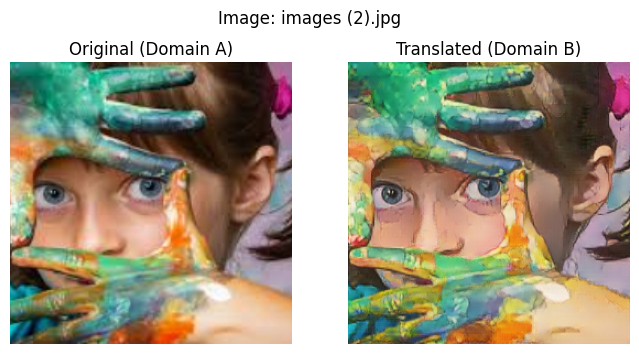

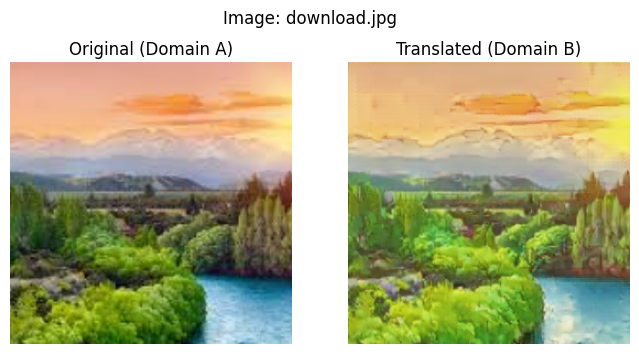

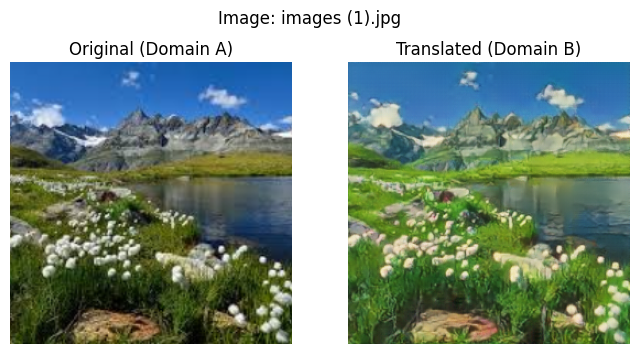

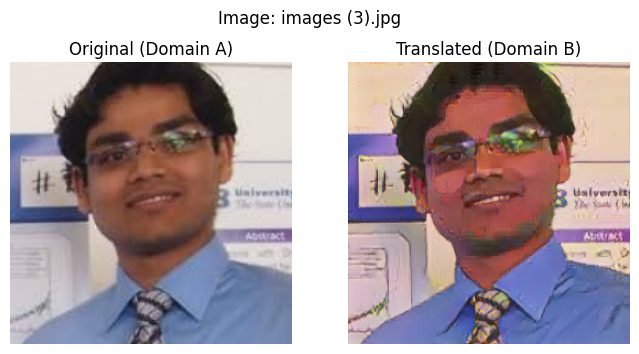

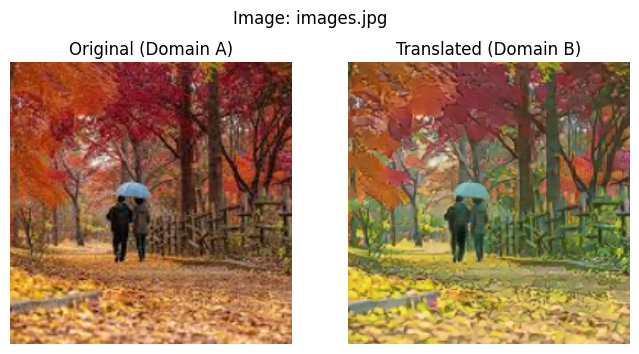

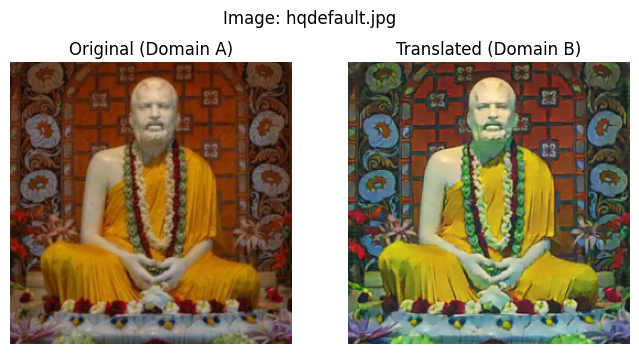

In [ ]:
for idx, (real_img, fake_img, img_name) in enumerate(translated_pairs):
    plt.figure(figsize=(8, 4))

    # Original image
    plt.subplot(1, 2, 1)
    plt.title('Original (Domain A)')
    plt.imshow(real_img.permute(1, 2, 0))  # C,H,W -> H,W,C
    plt.axis('off')

    # Translated image
    plt.subplot(1, 2, 2)
    plt.title('Translated (Domain B)')
    plt.imshow(fake_img.permute(1, 2, 0))
    plt.axis('off')

    plt.suptitle(f"Image: {img_name}", fontsize=12)
    plt.show()
